## DQN

We will start organizing the structure of the implementation. In general, there are 3 scripts to run a training with DQN agent on an environment. First of them is the model where the policies and loss function are implemented. Second one is the Trainer class where all the training and evaluation happens. This class is responsible for parameter updates, running the environment, and keeping track of necessary statistics as well as saving the model (agent and optimizer). Lastly, the third script that initiates the agent, trainer, environment, ... and starts the training with the given arguments.

- DQN
    - model
    - trainer
    - experiment (box2d)


We will be following a very similar structure for the Rainbow agent.

#### Running

Each experiment will be trained from scratch with a different seed 5 times to have a good understanding of the stochasticity involved in the training. You can run your experiments with command-line arguments from the ipython notebook as shown below.

In [1]:
#!python dqn/dqn/box2d.py --gamma 0.99

> You can also save your outputs to a file by running:

In [2]:
#python dqn/dqn/box2d.py --gamma 0.9 > logs/dqn_1.txt

#### Plotting

When you are done with experiments, you can plot the statistics. We are interested to see how much variation exists in the training. So, plot your results (5 of them) in a plot with two subplots one for rewards and the other for the td error. You can **parse** the training statistics from log files. You need to keep log files for submitting! Do not rely on the plots in the ipython notebook!

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot(train_rewards, eval_rewards, td_error):
    """ Plot the statistics.
        Arguments:
            - train_rewards: (5, N) dim array 
            - eval_rewards: (5, N) dim array
            - td_error: (5, N) dim array where N denotes iterations
    """
    for stat in (train_rewards, eval_rewards, td_error):
        if len(stat.shape) != 2:
            raise ValueError("Arguemnts must be 2 dimensional")
    
    x = np.arange(len(train_rewards[0]))
    
    fig = plt.figure(figsize=(14, 5))

    plt.subplot(121)
    plt.title("reward")
    plt.xlabel("Iteration")
    plt.ylabel("Episode reward")
    plt.plot(
        np.percentile(train_rewards, 50, axis=0),
        label="training"
    )
    plt.fill_between(
        x,
        np.percentile(train_rewards, 25, axis=0),
        np.percentile(train_rewards, 75, axis=0),
        alpha=0.5
    )

    plt.plot(
        np.percentile(eval_rewards, 50, axis=0),
        label="evaluation"
    )
    plt.fill_between(
        x,
        np.percentile(eval_rewards, 25, axis=0),
        np.percentile(eval_rewards, 75, axis=0),
        alpha=0.5
    )
    plt.legend()

    plt.subplot(122)
    plt.title("td error")
    plt.xlabel("Iteration")
    plt.ylabel("error")
    plt.plot(
        np.percentile(td_error, 50, axis=0),
        label="td"
    )
    plt.fill_between(
        x,
        np.percentile(td_error, 25, axis=0),
        np.percentile(td_error, 75, axis=0),
        alpha=0.5
    )
    plt.legend()

In [4]:
def plot_run(run_name):
    
    for run_id in range(5):

        with open(run_name+"_"+str(run_id+1)+".txt") as f:
            content = f.readlines()

        if run_id == 0:
            count = len(content) - 1
            different_train_rewards = np.zeros((5, count))
            different_eval_rewards = np.zeros((5, count))
            different_td_losses = np.zeros((5, count))
            
        train_rewards = []
        eval_rewards = []
        td_losses = []
       
        for lineid, line in enumerate(content):
            if lineid == 0:
                continue
            train_rewards.append(float(line.split(":")[2].split(",")[0].replace("nan","0.")))
            eval_rewards.append(float(line.split(":")[3].split(",")[0].replace("nan","0.")))
            td_losses.append(float(line.split(":")[4].split(",")[0].replace("nan","0.")))
            
        different_train_rewards[run_id,:] = np.array(train_rewards)
        different_eval_rewards[run_id,:] = np.array(eval_rewards)
        different_td_losses[run_id,:] = np.array(td_losses)
        
    plot(different_train_rewards, different_eval_rewards, different_td_losses)
        

### Implementation

We start filling the source code from ``` dqn/base_dqn.py ```. This class serves as a base class for DQN agents (Vanilla DQN and Rainbow DQN).

- ``` greedy_policy(self, state) ```
- ``` evaluate(self, eval_episode, env, device) ```

As you can see the target network is already initiated in the constructor of the base class. But we also need a replay buffer. The next part to implement is ``` dqn/replaybuffer/uniform.py ```. When we initiate the buffer we allocate all the memory and then gradually push transitions. Here the capacity is fixed and the size of the buffer grows as we push transitions.

- ``` push(self, transition) ``` Expecting a ```Transition``` object (namedtuple defined in the class).
Remember, our replay buffer is a queue with FIFO behavior.
- ``` sample(self, batchsize, *args) ``` Return a ```Transition``` of batched tensors(state, action, ... etc)


Next, we need to complete DQN class in ``` dqn/dqn/model.py ```.

- ``` loss(self, batch, gamma) ```

When we are done with DQN and replay buffer we can start implementing ``` dqn/dqn/train.py ```. This class takes care of all the training.

- ``` update(self, ix) ``` Update function updates the parameters (value and target networks). Also, append td error to the ```td_loss``` list
- ``` __iter__(self) ``` This python special method returns a generator that yields transition at every step for "n_iterations" steps (from ```args```). To see how we use ```__iter__``` please check the ```__call__``` method in the ```Trainer``` class. Additionally, append the episodic training reward if the environment is terminated. Step the epsilon here (comeback this point after next implementation)

We bring every component necessary for training in the ``` __call__ ``` method.

Before starting the experiments, we need to implement annealing functions located at ``` dqn/common.py ``` and initiate it in the constructor of the ``` Trainer ``` class. Remember epsilon is a python **generator**.

``` __init__(self, args, agent, opt, env): ``` Initiate epsilon (pick a strategy) based on ```args```. For example: If the ```epsilon-decay``` is given use exponential decaying strategy.

You can also modify the``` Writer ``` class if you like to.

Finally, we need to complete ``` ValueNet ``` implementation in ``` dqn/dqn/box2d.py ```.

### Experiments

We run our experiments in the "Lunar Lander" environment. Let's see if two of the innovations introduced in the DQN paper make a difference.

- Experiment (run training 5 times) DQN in Lunar Lander (default) environment with very small Replay Buffer and very frequent target updates (small value for ```target-update-period```)

- Experiment DQN in Lunar Lander with large Replay Buffer and target update period.

- Experiment DQN with exponential decaying epsilon strategy.

Remaining hyperparameters must be tuned. First two experiments are run with linear decaying.

Plot these results (3 Plots)

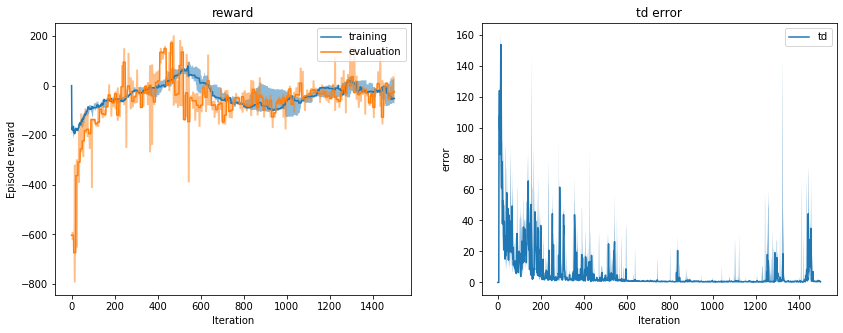

In [5]:
# Plot Experiment 1
# Namespace(batch_size=32, buffer_capacity=250, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.995, epsilon_init=1, epsilon_min=0.01, epsilon_range=200, eval_episode=5, eval_period=1000, gamma=0.99, lr=0.0003, max_episode_len=1000, model_dir='models/', n_iterations=150000, save_model=False, start_update=500, target_update_period=10, write_period=100)
plot_run("logs/dqn/dqn_1")

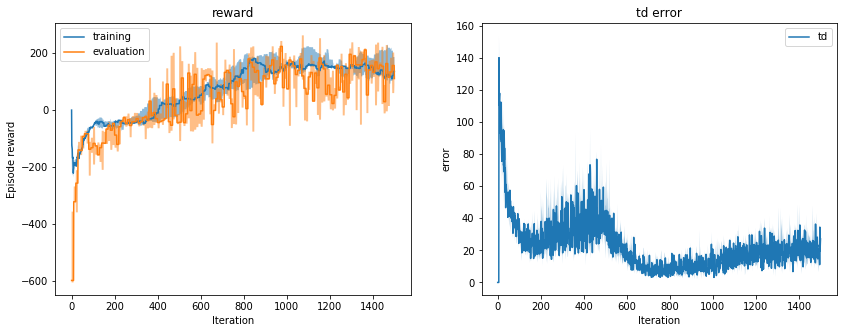

In [6]:
# Plot Experiment 2
# Namespace(batch_size=32, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.995, epsilon_init=1, epsilon_min=0.01, epsilon_range=200, eval_episode=5, eval_period=1000, gamma=0.99, lr=0.0003, max_episode_len=1000, model_dir='models/', n_iterations=150000, save_model=False, start_update=500, target_update_period=250, write_period=100)
plot_run("logs/dqn/dqn_2")

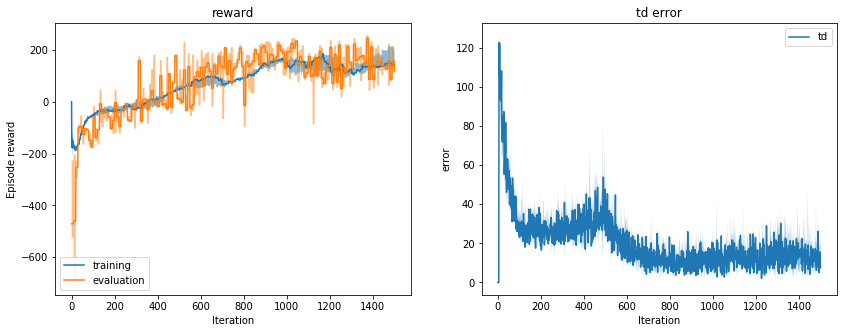

In [7]:
# Plot Experiment 3
# Namespace(batch_size=32, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.99, epsilon_init=1, epsilon_min=0.01, epsilon_range=None, eval_episode=5, eval_period=1000, gamma=0.99, lr=0.0003, max_episode_len=1000, model_dir='models/', n_iterations=150000, save_model=False, start_update=500, target_update_period=250, write_period=100)
plot_run("logs/dqn/dqn_3")

## Rainbow

We use DQN as a base for our implementation. Rainbow introduces a few extensions over vanilla DQN. Each of these extensions can be disabled in our implementation. We will test the Rainbow agent in both Lunar Lander and Pong.

### Implementation

#### Prioritized Buffer
Let's start with Prioritized Replay Buffer. To start implementing this buffer we need Segment Tree. Complete ```dqn/replaybuffer/seg_tree.py```

- ```SegTree``` Seg Tree is a base class for Min and Sum Trees. In this implementation, Seg Tree behaves as a FIFO Queue. Remember, the size of the tree and the capacity are not the same! Capacity is the number of leaves in the tree while size is the number of valid values (less than or equals to the capacity).

- ``` MinTree ```
- ``` SumTree ```

Since we have necessary data structures we can move on to the Prioritized Replay Buffer implementation in ``` dqn/replaybuffer/prioritized.py ```

- ``` PriorityBuffer ``` Similar to Uniform Buffer but with additional features

**Prioritized Buffer** causes a few changes in the code.
- ```update``` function in the ```Trainer``` class located at ```dqn/rainbow/train.py```
- ``` loss ``` functions (two of them) in the ```Rainbow``` class. Loss tensor must not be averaged over the batch axis! In the ```update``` function we will be taking a weighted average of the loss tensor with weights from the samples to ensure Importance sampling (see the paper for further details).

Remember this while implementing ```update``` function!

- - -

#### Distributional RL

This extension improves the performance greatly. Let's start implementing Distributional loss at ```dqn/rainbow/model.py```. This is a little bit tricky, so be careful!
- ```distributional_loss(self, batch, gamma) ```
- ```expected_value(self, values)```
- ```greedy_policy(self, state, *args)``` Greedy policy needs to be modified!
- ```vanilla_loss(self, batch, gamma)``` When distributional is deactivated this one will be used (see ```loss``` method in the ```Rainbow``` class)

Use ```_next_action_network(self)``` to obtain target actions so that the loss functions become compatible with double Q-learning.
- - -

#### Multi-step Learning

There is no one way of using n-step learning so we will be picking a simple way. Yield a transition with a reward that equals to the sum of n consecutive rewards (discounted by gamma) and the nth next state as the next_state. You can find this way of using n-step learning in Chapter 7 of the textbook (without Importance Sampling or Tree Backup, similar to n-step Sarsa but without Sarsa).

``` dqn/rainbow/train.py ```
- ``` __iter__(self)```

- - -
#### Double Q-learning

In double Q learning, the target value is calculated with the actions selected from the online network(```valuenet```). Since we used ```_next_action_network(self)``` in loss functions. We only need to fill this part (```_next_action_network(self)```).

- - -
#### Noisy Net

In this part, we need to complete ```NoisyLayer``` in ```dqn/rainbow/layers.py```. Moreover, when we use "noisy-network" we can act greedily since stochasticity is built in the network. In ```__iter__``` method at ``` dqn/rainbow/train.py``` use ```greedy_policy``` if noisy-net is active.

- - - 
#### Dueling Architecutre

You can implement Dueling architecture by filling ```HeadLayer``` class in the ```dqn/rainbow/layers.py```. Remember, the structure of this class depends on Dueling, Distributional and Noisy Nets.

- - - 
#### Rainbow

Once you completed all the extensions you can combine them. Complete the implementation by filling:

- ```update(self, ix)``` at ```dqn/rainbow/train.py```. This part is affected by more than 1 extension, consider this while implementing.
- In box2D, initialize a fully connected network that follows the head layer. ```dqn/rainbow/box2d.py```
- In pong, initialize a convolutional network that reduces the spatial size into 5 by 5 (or any other value that you prefer). ```dqn/rainbow/pong.py```


### Experiments

We will be testing each extension on its own. Run ```box2d.py``` by enabling one extension at a time and plot the results (5 runs per experiment) (6 plots). An example run is given below for prioritized only experiment.

In [8]:
#!python dqn/rainbow/box2d.py --no-dist --no-dueling --n-step 1 --no-double --no-prioritized --no-noisy #> logs/rainbow/prior_1.txt

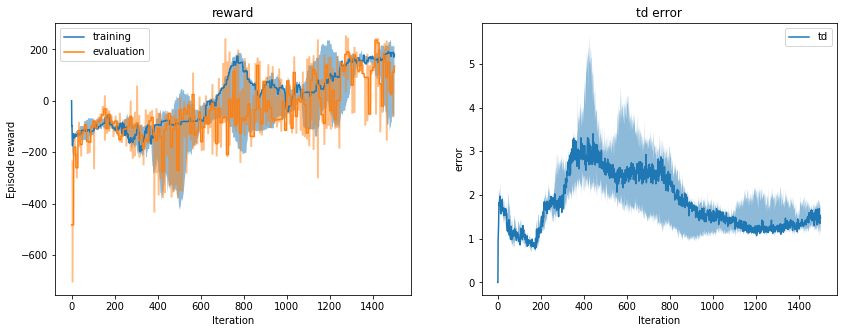

In [9]:
# Plot Experiment with prioritized
# Namespace(alpha=0.6, batch_size=32, beta_init=0.4, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.925, epsilon_init=1, epsilon_min=0.01, epsilon_range=None, eval_episode=3, eval_period=1000, gamma=0.99, lr=0.001, max_episode_len=1000, model_dir='models/', n_iterations=150000, n_steps=1, natoms=51, no_dist=True, no_double=True, no_dueling=True, no_noisy=True, no_prioritized=False, noisy_std=0.5, save_model=False, start_update=100, target_update_period=500, vmax=200, vmin=-200, write_period=100)
plot_run("logs/rainbow/rainbow_1")

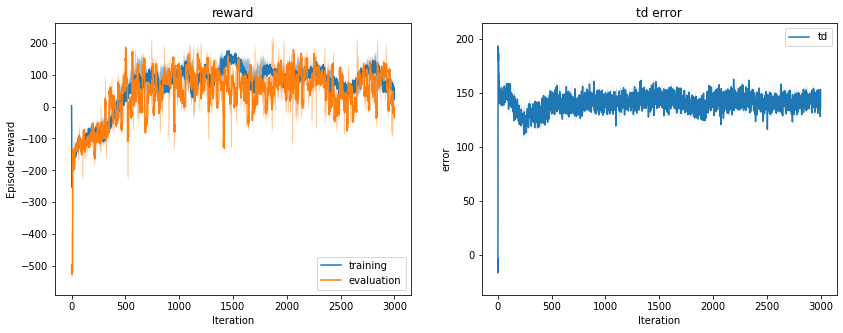

In [10]:
# Plot Experiment with distributional
# Namespace(alpha=0.6, batch_size=32, beta_init=0.4, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.925, epsilon_init=1, epsilon_min=0.01, epsilon_range=None, eval_episode=3, eval_period=1000, gamma=0.99, lr=0.001, max_episode_len=1000, model_dir='models/', n_iterations=150000, n_steps=1, natoms=51, no_dist=False, no_double=True, no_dueling=True, no_noisy=True, no_prioritized=True, noisy_std=0.5, save_model=False, start_update=100, target_update_period=500, vmax=200, vmin=-200, write_period=100)
plot_run("logs/rainbow/rainbow_2")

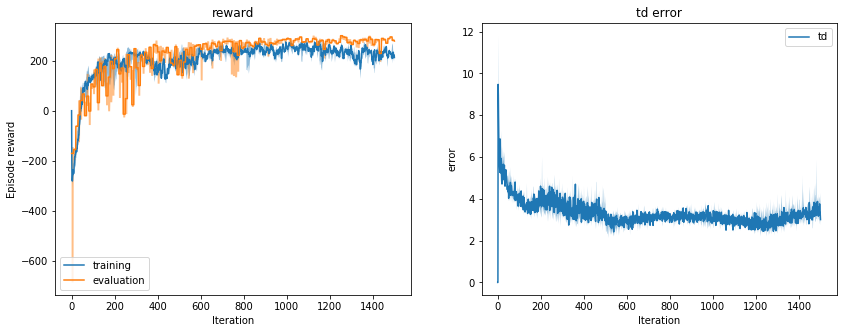

In [11]:
# Plot Experiment with multi-step
# Namespace(alpha=0.6, batch_size=32, beta_init=0.4, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.925, epsilon_init=1, epsilon_min=0.01, epsilon_range=None, eval_episode=3, eval_period=1000, gamma=0.99, lr=0.001, max_episode_len=1000, model_dir='models/', n_iterations=150000, n_steps=5, natoms=51, no_dist=True, no_double=True, no_dueling=True, no_noisy=True, no_prioritized=True, noisy_std=0.5, save_model=False, start_update=100, target_update_period=500, vmax=200, vmin=-200, write_period=100)
plot_run("logs/rainbow/rainbow_3")

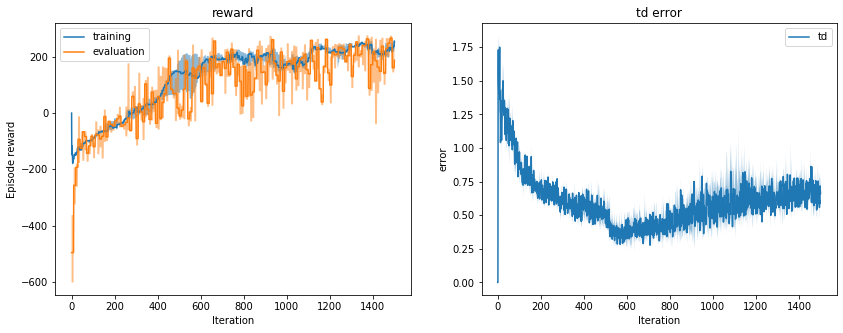

In [12]:
# Plot Experiment with double
# Namespace(alpha=0.6, batch_size=32, beta_init=0.4, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.925, epsilon_init=1, epsilon_min=0.01, epsilon_range=None, eval_episode=3, eval_period=1000, gamma=0.99, lr=0.001, max_episode_len=1000, model_dir='models/', n_iterations=150000, n_steps=1, natoms=51, no_dist=True, no_double=False, no_dueling=True, no_noisy=True, no_prioritized=True, noisy_std=0.5, save_model=False, start_update=100, target_update_period=500, vmax=200, vmin=-200, write_period=100)
plot_run("logs/rainbow/rainbow_4")

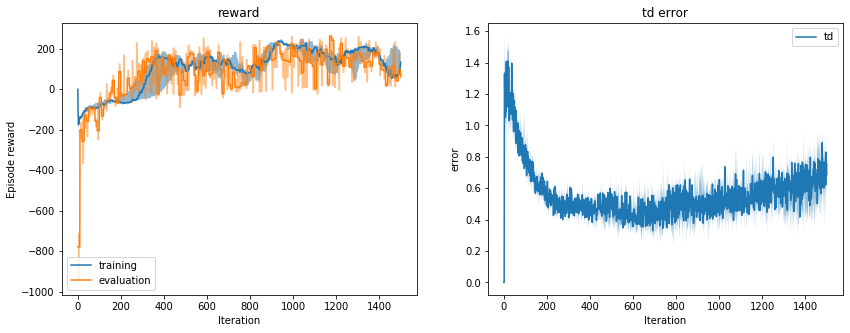

In [13]:
# Plot Experiment with dueling
# Namespace(alpha=0.6, batch_size=32, beta_init=0.4, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.925, epsilon_init=1, epsilon_min=0.01, epsilon_range=None, eval_episode=3, eval_period=1000, gamma=0.99, lr=0.001, max_episode_len=1000, model_dir='models/', n_iterations=150000, n_steps=1, natoms=51, no_dist=True, no_double=True, no_dueling=False, no_noisy=True, no_prioritized=True, noisy_std=0.5, save_model=False, start_update=100, target_update_period=500, vmax=200, vmin=-200, write_period=100)
plot_run("logs/rainbow/rainbow_5")

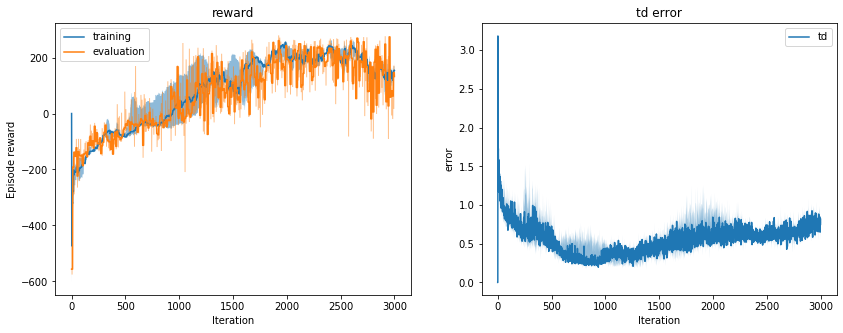

In [14]:
# Plot Experiment with noisy
# Namespace(alpha=0.6, batch_size=32, beta_init=0.4, buffer_capacity=50000, clip_grad=True, device='cuda', envname='LunarLander-v2', epsilon_decay=0.925, epsilon_init=1, epsilon_min=0.01, epsilon_range=None, eval_episode=3, eval_period=1000, gamma=0.99, lr=0.001, max_episode_len=1000, model_dir='models/', n_iterations=150000, n_steps=1, natoms=51, no_dist=True, no_double=True, no_dueling=True, no_noisy=False, no_prioritized=True, noisy_std=0.5, save_model=False, start_update=100, target_update_period=500, vmax=200, vmin=-200, write_period=100)
plot_run("logs/rainbow/rainbow_6")

**ATARI**

The next step is to train **Pong** with the Rainbow agent. This time, please enable model saving ```--save-model``` and upload the model parameters that returns the highest evaluation score to google drive. Put the link at the end of the notebook.

Note: No need to run Pong for more than 1 run!

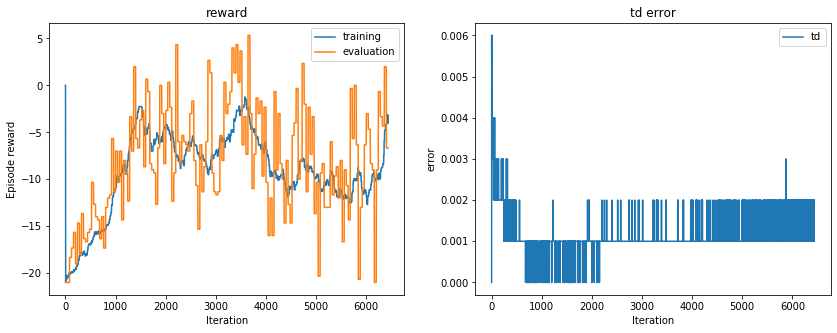

In [15]:
# Plot the result (no need to use plot function defined above)

def plot_run(run_name):
    
    for run_id in range(1):

        with open(run_name+"_"+str(run_id+1)+".txt") as f:
            content = f.readlines()

        if run_id == 0:
            count = len(content) - 1
            different_train_rewards = np.zeros((1, count))
            different_eval_rewards = np.zeros((1, count))
            different_td_losses = np.zeros((1, count))
            
        train_rewards = []
        eval_rewards = []
        td_losses = []
       
        for lineid, line in enumerate(content):
            if lineid == 0:
                continue
            train_rewards.append(float(line.split(":")[2].split(",")[0].replace("nan","0.")))
            eval_rewards.append(float(line.split(":")[3].split(",")[0].replace("nan","0.")))
            td_losses.append(float(line.split(":")[4].split(",")[0].replace("nan","0.")))
            
        different_train_rewards[run_id,:] = np.array(train_rewards)
        different_eval_rewards[run_id,:] = np.array(eval_rewards)
        different_td_losses[run_id,:] = np.array(td_losses)
        
    plot(different_train_rewards, different_eval_rewards, different_td_losses)

plot_run("logs/atari/pong")

We changed the wrapper a bit, so it wouldn't be opened by the scripts given with the homework. We are stacking 4 consecutive frames to create an input.

[Meh Pongv4 Model (+5.333 Logged Reward)](https://drive.google.com/drive/folders/1tgqjmL2-7Aq2FOvip71wLS2O32PpEt34?usp=sharing)

In [22]:
!python dqn/rainbow/pong.py --eval-mode --eval-period 1 --eval-episode 1 --write-period 1 --n-iterations 3

/home/nlztrk/anaconda3/envs/drl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/home/nlztrk/anaconda3/envs/drl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nlztrk/anaconda3/envs/drl/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Iteration:       0, Train reward:     nan, Eval reward:  -5.000, TD loss:     nan, Episode:    0, Epsilon:    1
Iteration:       1, Train reward:     nan, Eval reward:   2.000, TD loss:     nan, Episode:    0, Epsilon:    1
Iteration:       2, Train reward:     nan, Eval reward:  -3.000, TD loss:     nan, Episode:    0, Epsilon:    1
Iteration:       3, Train reward:     nan, Eval reward:   2.000, TD loss:     nan, Episode:    0, E